# 3D example:

The operator here is $$\Phi \mu = \int \phi(x,y,t) \mathrm{d}\mu(x,y,t)$$ where
$$
\phi(x,y,t) =\left(\exp(-(x_i - x)^2/(2\sigma^2)) \exp(-(y_j-y)^2/(2\sigma)) \exp(-s_k t) \right)_{i,j,k}
$$

In [52]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import time

import mmd as mmd
import operators as myops
import lasso as ls
import continuous_BP as cbp
from helper import prune
from importlib import reload  # Python 3.4+
from numpy import linspace

reload(ls)
reload(myops)
reload(cbp)

<module 'continuous_BP' from '/Users/u2272691/Documents/GitHub/continuous-BP/Python/cBP_paper/continuous_BP.py'>

In [53]:
#define the operator matrices

from  numpy import dot as dot

nx= [5,5]
xgrid1 = linspace(0,1,nx[0])
xgrid2 = linspace(0,1,nx[1])
tvec = np.linspace(0,1,10)

sigma=0.1
Xop, dXop = myops.getGaussianOp(tvec,sigma)
X, dX  = Xop(xgrid1), dXop(xgrid1)
Y, dY = Xop(xgrid1), dXop(xgrid1)

T = 2
tvec2 = np.linspace(0,1,T)
Psi, dPsi = myops.getLaplaceOp(tvec2)
B, dB  = Psi(xgrid2), dPsi(xgrid2)

In [54]:
points = np.array([np.array([x,y,z]) for x in xgrid1 for y in xgrid1 for z in xgrid2])
def SRLasso(y_obs,la,tau1,tau2,tol=1e-8):
    a,b1,b2,b3 = cbp.SRLasso_3DTensor(X,Y,B,dX,dY,dB, y_obs,la,[tau1,tau1,tau2])
    a,grid = prune( a, points + np.stack((b1,b2,b3),axis=1),tol)
    return a, grid





In [55]:
#define Lasso solver

#forward and adjoint operations
def FWD_lasso(x):
    x0 = x[:,:,0]
    return dot(dot(X,dot(Y,x0)),B.T)

def ADJ_lasso(x):
    z = dot(dot(X.T,dot(Y.T,x)),B)
    return z[:,:,None]  


def Grid_Lasso(y_obs,la,tol=1e-8):   
    #run lasso solver
    a = ls.Lasso_Tensor(FWD_lasso,ADJ_lasso, y_obs,la)
    #prune coefficients below tolerance
    al_val, grid_lasso = prune(a.reshape(-1),points,tol)
    return  al_val, grid_lasso




In [56]:
#define ground truth
h1 = xgrid1[1]-xgrid1[0]
h2 = xgrid2[1]-xgrid2[0]

spacing = np.array([0.1,0.1,.1])
shift = np.array([[h1,h1,-h2],[h1,-h1,h2]])*spacing[None,:]
x_true = np.array( [ [xgrid1[nx[0]//4],xgrid1[nx[0]//4],xgrid2[nx[1]//4]], 
                    [xgrid1[3*nx[0]//4],xgrid1[3*nx[0]//4],xgrid2[nx[1]//2]] ]  ) + shift
a_true = np.array([3, 2])

y_true = np.einsum('nj,kj,lj->nkl', Xop(x_true[:,0]),Yop(x_true[:,1]), Psi(x_true[:,2])*a_true[None,:]) 


In [57]:
reload(ls)

np.random.seed(1)

noise_lev = 0.00001
y_obs = y_true + noise_lev*np.random.randn( *y_true.shape)


#rerun both with same noise instance
la = 0.001
tau1,tau2= 1,1

a,grid = SRLasso(y_obs,la,tau1,tau2,1e-2)




print(a.shape,grid.shape)
print('SR Lasso error',mmd.mmd_laplace(x_true, a_true,grid,a))

al_val,grid_lasso = Grid_Lasso(y_obs,la,1e-2)
print('Lasso error',mmd.mmd_laplace(x_true, a_true,grid_lasso,al_val))


(12,) (12, 3)
SR Lasso error 0.0797824261866873
Lasso error 2.1719580791559823


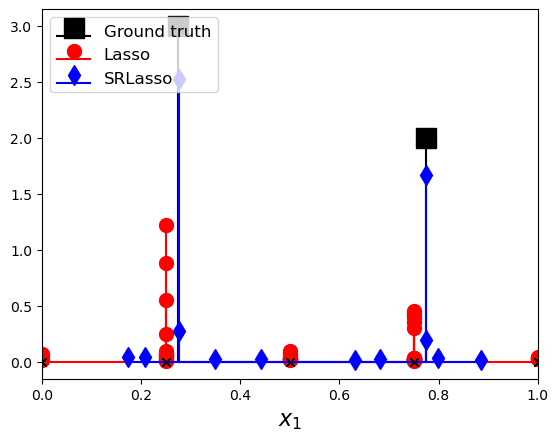

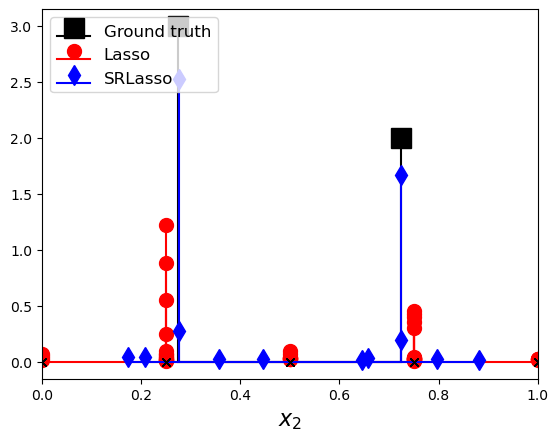

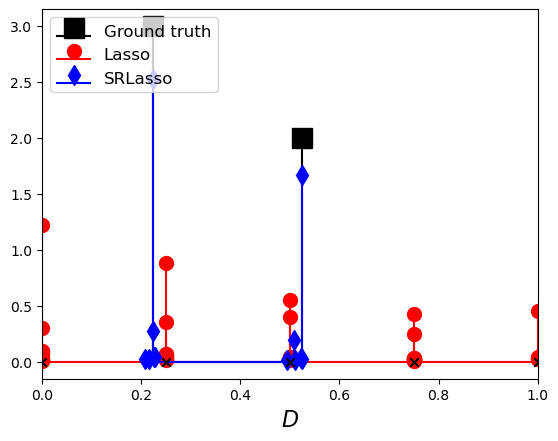

In [58]:

#plot along dim 1
markerline, stemlines, baseline = plt.stem(x_true[:,0], np.abs(a_true),'k',linefmt='k-',markerfmt='ks',basefmt='k-',label='Ground truth')
plt.setp(markerline,  markersize = 15)

markerline, stemlines, baseline = plt.stem(grid_lasso[:,0],np.abs(al_val),'r',linefmt='r-',markerfmt='ro',basefmt='r-',label='Lasso')
plt.setp(markerline,  markersize = 10)
markerline, stemlines, baseline =  plt.stem(grid[:,0],np.abs(a),linefmt='b-', 
                                            markerfmt='bd',basefmt='b-',label='SRLasso')
plt.plot(points[:,0], 0*points[:,0],'kx')

plt.setp(markerline,  markersize = 10)
plt.xlim([0,1])

plt.legend( fontsize="12",loc='upper left')
plt.xlabel('$x_1$',fontsize="16")

plt.show()

#plot along dim 2

plt.plot(points[:,1], 0*points[:,0],'kx')
markerline, stemlines, baseline = plt.stem(x_true[:,1], np.abs(a_true),'k',linefmt='k-',markerfmt='ks',basefmt='k-',label='Ground truth')
plt.setp(markerline,  markersize = 15)

markerline, stemlines, baseline =plt.stem(grid_lasso[:,1],np.abs(al_val),'r',linefmt='r-',markerfmt='ro',basefmt='r-',label='Lasso')
plt.setp(markerline,  markersize = 10)

markerline, stemlines, baseline = plt.stem(grid[:,1],np.abs(a),linefmt='b-',markerfmt='bd',basefmt='b-',label='SRLasso')
plt.plot(points[:,1], 0*points[:,0],'kx')

plt.setp(markerline,  markersize = 10)


plt.xlim([0,1])

plt.xlabel('$x_2$',fontsize="16")

plt.legend( fontsize="12",loc='upper left')

plt.show()

#plot along dim 1

plt.plot(points[:,2], 0*points[:,0],'kx')
markerline, stemlines, baseline = plt.stem(x_true[:,2], np.abs(a_true),'k',linefmt='k-',markerfmt='ks',basefmt='k-',label='Ground truth')
plt.setp(markerline,  markersize = 15)

markerline, stemlines, baseline =plt.stem(grid_lasso[:,2],np.abs(al_val),'r',linefmt='r-',markerfmt='ro',basefmt='r-',label='Lasso')
plt.setp(markerline,  markersize = 10)

markerline, stemlines, baseline = plt.stem(grid[:,2],np.abs(a),linefmt='b-',markerfmt='bd',basefmt='b-',label='SRLasso')
plt.plot(points[:,2], 0*points[:,0],'kx')

plt.setp(markerline,  markersize = 10)


plt.xlim([0,1])

plt.xlabel('$D$',fontsize="16")

plt.legend( fontsize="12",loc='upper left')

plt.savefig('results/comparison_2.png', bbox_inches='tight')

In [59]:

#lambda range to test on
L=5
la_max = 0.005
la_vals = np.logspace(-5,np.log10(la_max/3),L)

Runs = 5
Res_Lasso = np.zeros((L,Runs))
Res_SRLasso = np.zeros((L,Runs))


Supp_Lasso = np.zeros((L,Runs))
Supp_SRLasso = np.zeros((L,Runs))


for r in range(Runs):
    np.random.seed(1+r)
    y_obs = y_true + noise_lev*np.random.randn( *y_true.shape) 
    for i in range(L):
        la = la_vals[i]
        al_val,grid_lasso = Grid_Lasso(y_obs,la,1e-2) 
        
        Res_Lasso[i,r] = mmd.mmd_laplace(x_true, a_true, grid_lasso, al_val)
        Supp_Lasso[i,r] = len(al_val)
        
        a,grid = SRLasso(y_obs,la,1,1,1e-2)
        Res_SRLasso[i,r] = mmd.mmd_laplace(x_true, a_true, grid, a)
        Supp_SRLasso[i,r] = len(a)


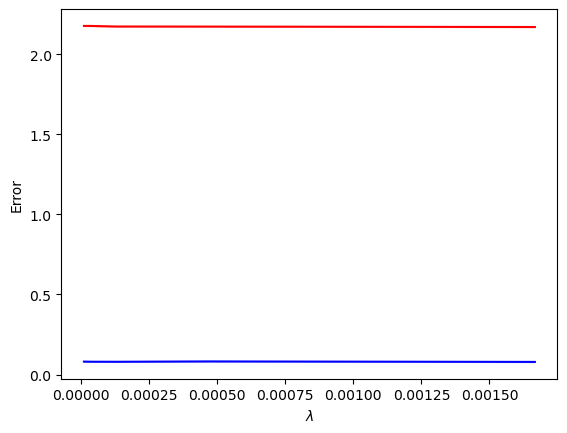

Text(0, 0.5, 'support')

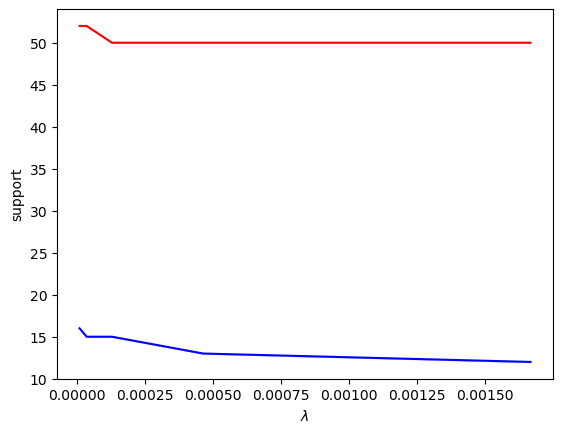

In [60]:

def makeplot(x,E,color,legend=''):
    mean_curve = np.mean(E, axis=1)
    std_curve = np.std(E, axis=1)
    lower_bound = mean_curve - 1 * std_curve
    upper_bound = mean_curve + 1 * std_curve
    plt.plot(x, mean_curve, color=color,label=legend)
    plt.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.2)


makeplot(la_vals,Res_Lasso,'r',legend='')
makeplot(la_vals,Res_SRLasso,'b',legend='')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')

plt.show()
makeplot(la_vals,Supp_Lasso,'r',legend='')
makeplot(la_vals,Supp_SRLasso,'b',legend='')
plt.xlabel(r'$\lambda$')
plt.ylabel('support')